## physbo example notebook

In [1]:
%load_ext lab_black

In [2]:
# 必要なライブラリーのインストール
import numpy as np
import matplotlib.pyplot as plt
import physbo
import itertools

%matplotlib inline

## テスト関数の作成
今回は2目的最適化

In [3]:
def vlmop2_minus(x):
    n = x.shape[1]
    y1 = 1 - np.exp(-1 * np.sum((x - 1 / np.sqrt(n)) ** 2, axis=1))
    y2 = 1 - np.exp(-1 * np.sum((x + 1 / np.sqrt(n)) ** 2, axis=1))

    return np.c_[-y1, -y2]

探索範囲の指定

In [4]:
a = np.linspace(-2, 2, 101)
test_X = np.array(list(itertools.product(a, a)))

simulator の定義

In [5]:
class simulator(object):
    def __init__(self, X):
        self.t = vlmop2_minus(X)

    def __call__(self, action):
        return self.t[action]

In [6]:
simu = simulator(test_X)

関数のプロット
- 1つ目の目的関数は右上にピーク
- 2つ目の目的関数は左下にピーク

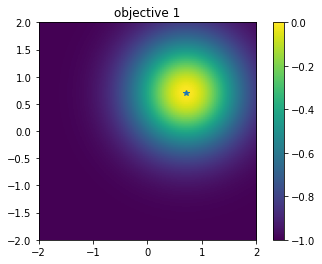

In [7]:
# plot objective 1
plt.figure()
plt.imshow(
    simu.t[:, 0].reshape((101, 101)),
    vmin=-1.0,
    vmax=0.0,
    origin="lower",
    extent=[-2.0, 2.0, -2.0, 2.0],
)
plt.title("objective 1")
plt.colorbar()
plt.plot([1.0 / np.sqrt(2.0)], [1.0 / np.sqrt(2.0)], "*")
plt.show()

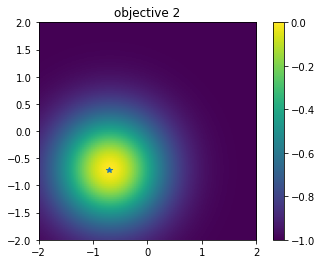

In [8]:
# plot objective 2
plt.figure()
plt.imshow(
    simu.t[:, 1].reshape((101, 101)),
    vmin=-1.0,
    vmax=0.0,
    origin="lower",
    extent=[-2.0, 2.0, -2.0, 2.0],
)
plt.title("objective 2")
plt.colorbar()
plt.plot([-1.0 / np.sqrt(2.0)], [-1.0 / np.sqrt(2.0)], "*")
plt.show()

## 最適化の実行

- policyのセット
- 多目的最適化用のphysbo.search.discrete_multi.policyを利用
- num_objectivesに目的関数の数を指定

In [9]:
policy = physbo.search.discrete_multi.policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

#### ランダムサーチ

In [10]:
policy = physbo.search.discrete_multi.policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

res_random = policy.random_search(
    max_num_probes=50, simulator=simu, disp_pareto_set=True
)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   current Pareto set = [[-0.99973003 -0.62334035]] (steps = [1]) 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   current Pareto set = [[-0.99973003 -0.62334035]
 [-0.99789981 -0.99866427]] (steps = [1 2]) 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   current Pareto set = [[-0.99090897 -0.46609239]] (steps = [3]) 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]] (steps = [4]) 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]
 [-0.67969326 -0.99981691]] (steps = [4 5]) 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]
 [-0.45601619 -0.99848443]] (steps =

パレート解の取得

In [11]:
front, front_num = res_random.export_pareto_front()
front, front_num

(array([[-0.95713719, -0.09067194],
        [-0.92633083, -0.29208351],
        [-0.63329589, -0.63329589],
        [-0.52191048, -0.72845916],
        [-0.26132949, -0.87913689],
        [-0.17190645, -0.91382463]]),
 array([40,  3, 19, 16, 29, 41]))

パレート解の可視化

In [12]:
def plot_pareto_front(res):
    front, front_num = res.export_pareto_front()
    dominated = [i for i in range(res.num_runs) if i not in front_num]
    points = res.fx[dominated, :]

    plt.figure(figsize=(7, 7))
    plt.scatter(res.fx[dominated, 0], res.fx[dominated, 1], c="blue")
    plt.scatter(front[:, 0], front[:, 1], c="red")
    plt.title("Pareto front")
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.xlim([-1.0, 0.0])
    plt.ylim([-1.0, 0.0])

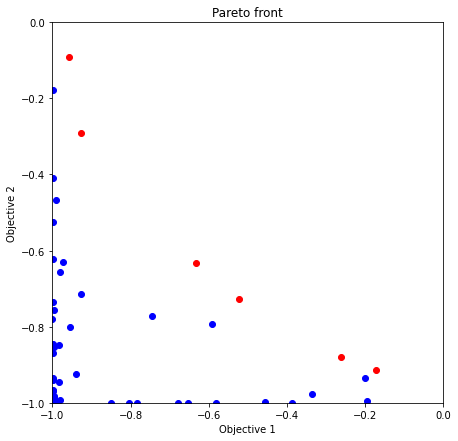

In [13]:
plot_pareto_front(res_random)

#### ベイズ最適化

ベイズ最適化は、下記3パターンの方法があるそうです。
- HVPI (Hypervolume-based Probability of Improvement)
- EHVI (Expected Hyper-Volume Improvement)
- TS (Thompson Sampling)

#### HVPI (Hypervolume-based Probability of Improvement) 
多次元の目的関数空間における非劣解領域 (non-dominated region) の改善確率をscoreとして算出する。

In [14]:
%%time
policy = physbo.search.discrete_multi.policy(test_X=test_X,
                                             num_objectives=2
                                            )
policy.set_seed(0)

policy.random_search(max_num_probes=10,
                     simulator=simu
                    )
res_HVPI = policy.bayes_search(max_num_probes=40,
                               simulator=simu,
                               score='HVPI',
                               interval=10
                              )

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

パレート解の取得

In [15]:
front, front_num = res_HVPI.export_pareto_front()
front, front_num

(array([[-9.82978321e-01, -3.32414921e-04],
        [-9.71056940e-01, -3.45637262e-02],
        [-9.50786244e-01, -6.76228653e-02],
        [-9.34458810e-01, -1.15668709e-01],
        [-9.13824628e-01, -1.71906452e-01],
        [-8.88492700e-01, -2.36876025e-01],
        [-8.68576210e-01, -2.82707709e-01],
        [-8.57549341e-01, -3.05692550e-01],
        [-8.33710080e-01, -3.53626320e-01],
        [-8.20907701e-01, -3.78330099e-01],
        [-7.92933832e-01, -4.26778524e-01],
        [-7.77704642e-01, -4.50447880e-01],
        [-7.62117827e-01, -4.74823143e-01],
        [-7.45438101e-01, -4.98117246e-01],
        [-7.28459156e-01, -5.21910482e-01],
        [-7.14031659e-01, -5.50368010e-01],
        [-6.92015440e-01, -5.67552511e-01],
        [-6.72522879e-01, -5.89370083e-01],
        [-6.52909089e-01, -6.11332656e-01],
        [-6.32120559e-01, -6.32120559e-01],
        [-6.11332656e-01, -6.52909089e-01],
        [-5.89370083e-01, -6.72522879e-01],
        [-5.70311337e-01, -6.939

パレート解のプロット

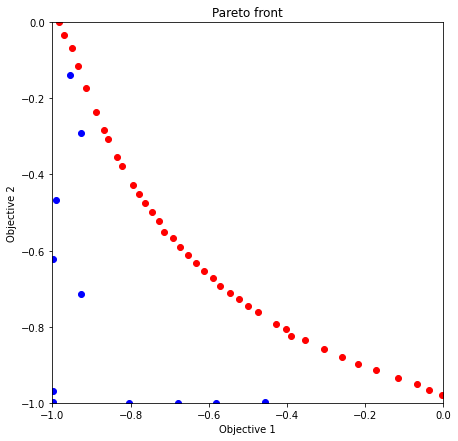

In [16]:
plot_pareto_front(res_HVPI)

#### EHVI (Expected Hyper-Volume Improvement) 
多次元の目的関数空間における非劣解領域 (non-dominated region) の改善期待値をscoreとして算出。

In [17]:
%%time
policy = physbo.search.discrete_multi.policy(test_X=test_X,
                                             num_objectives=2
                                            )
policy.set_seed(0)

policy.random_search(max_num_probes=10,
                     simulator=simu
                    )
res_EHVI = policy.bayes_search(max_num_probes=40,
                               simulator=simu,
                               score='EHVI',
                               interval=10
                              )

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

パレート解の取得

In [18]:
front, front_num = res_EHVI.export_pareto_front()
front, front_num

(array([[-9.82978321e-01, -3.32414921e-04],
        [-9.80950206e-01, -9.00606888e-04],
        [-9.76216469e-01, -5.22440276e-03],
        [-9.57137187e-01, -9.06719444e-02],
        [-9.34458810e-01, -1.15668709e-01],
        [-9.13824628e-01, -1.71906452e-01],
        [-8.88492700e-01, -2.36876025e-01],
        [-8.69414636e-01, -2.87283720e-01],
        [-8.33710080e-01, -3.53626320e-01],
        [-8.07119688e-01, -4.02089723e-01],
        [-7.77704642e-01, -4.50447880e-01],
        [-7.66641597e-01, -4.84810355e-01],
        [-7.28459156e-01, -5.21910482e-01],
        [-6.72522879e-01, -5.89370083e-01],
        [-6.32120559e-01, -6.32120559e-01],
        [-6.11332656e-01, -6.52909089e-01],
        [-5.46030757e-01, -7.11273143e-01],
        [-4.98117246e-01, -7.45438101e-01],
        [-4.50447880e-01, -7.77704642e-01],
        [-3.78330099e-01, -8.20907701e-01],
        [-3.07910783e-01, -8.58004455e-01],
        [-2.36876025e-01, -8.88492700e-01],
        [-1.52666236e-01, -9.212

パレート解のプロット

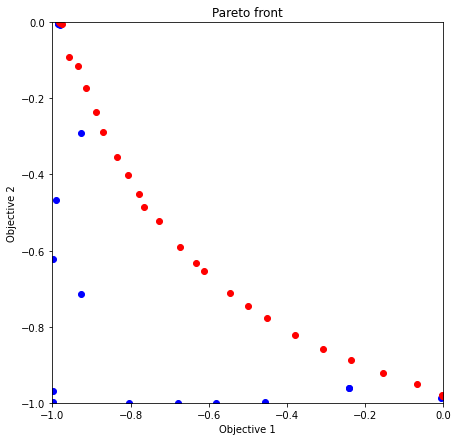

In [19]:
plot_pareto_front(res_EHVI)

#### TS (Thompson Sampling) 
単目的の場合の Thompson Sampling では、各候補(test_X)について、目的関数の事後分布からサンプリングを行い、値が最大となる候補を次の探索点として推薦します。
多目的の場合は、サンプリングした値についてパレートルールの上で最大となる候補、つまりパレート最適な候補の中からランダムに1つ選択して次の探索点とします。

In [20]:
%%time
policy = physbo.search.discrete_multi.policy(test_X=test_X,
                                             num_objectives=2
                                            )
policy.set_seed(0)

policy.random_search(max_num_probes=10,
                     simulator=simu
                    )
res_TS = policy.bayes_search(max_num_probes=40,
                             simulator=simu,
                             score='TS',
                             interval=10,
                             num_rand_basis=5000
                            )

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

パレート解の取得

In [21]:
front, front_num = res_TS.export_pareto_front()
front, front_num

(array([[-0.92633083, -0.29208351],
        [-0.87672383, -0.32717624],
        [-0.63405159, -0.70815636],
        [-0.56098434, -0.80114509],
        [-0.40174969, -0.82765448],
        [-0.30972959, -0.87352722],
        [-0.24174442, -0.88920407],
        [-0.17455212, -0.91409995],
        [-0.13248591, -0.9357052 ],
        [-0.08294372, -0.9457967 ],
        [-0.03257006, -0.96363279],
        [-0.01213244, -0.97355249],
        [-0.01213244, -0.97355249],
        [-0.0113618 , -0.98801109]]),
 array([ 3, 25, 28, 16, 21, 20, 42, 26, 30, 22, 46, 40, 45, 31]))

パレート解のプロット

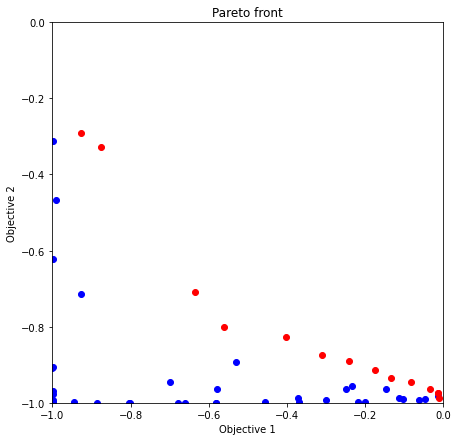

In [22]:
plot_pareto_front(res_TS)

#### 全探索
random_search で max_num_probes に全データ数 (N = test_X.shape[0]) を渡すと全探索

In [23]:
%%time
policy = physbo.search.discrete_multi.policy(test_X=test_X,
                                             num_objectives=2
                                            )
policy.set_seed(0)

N = test_X.shape[0]
res_all = policy.random_search(max_num_probes=N,
                               simulator=simu
                              )

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

パレート解の取得

In [24]:
front, front_num = res_all.export_pareto_front()
front, front_num

(array([[-9.82978321e-01, -3.32414921e-04],
        [-9.80950206e-01, -9.00606888e-04],
        [-9.80950206e-01, -9.00606888e-04],
        [-9.78680443e-01, -1.46847591e-03],
        [-9.76216469e-01, -5.22440276e-03],
        [-9.76216469e-01, -5.22440276e-03],
        [-9.73467725e-01, -8.96620187e-03],
        [-9.70495864e-01, -1.58482562e-02],
        [-9.70495864e-01, -1.58482562e-02],
        [-9.67191127e-01, -2.26825194e-02],
        [-9.63632790e-01, -3.25700576e-02],
        [-9.63632790e-01, -3.25700576e-02],
        [-9.59688528e-01, -4.23575634e-02],
        [-9.55459244e-01, -5.50746531e-02],
        [-9.55459244e-01, -5.50746531e-02],
        [-9.50786244e-01, -6.76228653e-02],
        [-9.45796704e-01, -8.29437228e-02],
        [-9.45796704e-01, -8.29437228e-02],
        [-9.40301299e-01, -9.80128274e-02],
        [-9.34458810e-01, -1.15668709e-01],
        [-9.34458810e-01, -1.15668709e-01],
        [-9.28044538e-01, -1.32978986e-01],
        [-9.21254913e-01, -1.526

パレート解のプロット

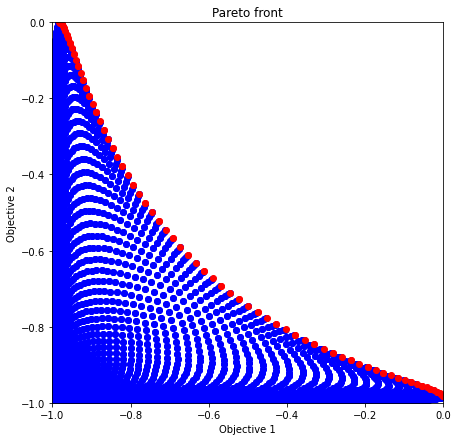

In [25]:
plot_pareto_front(res_all)